In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from dask.dataframe.utils import make_meta
import matplotlib.pyplot as plt 
import numpy as np  
import lsdb
import pandas as pd
from catalog_filtering import bandFilterLenient, contains_PM

In [2]:
#Bands we care about
bandList = ['G','R','I','Z','Y']

#Keeping only the important columns
crucialCols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)

catalog = lsdb.read_hipscat('hipscat/des_one_deg/', columns=crucialCols)

#Filtering for specific measurement vaTlues
qs = bandFilterLenient(bandList,classStar=0.95,spreadModel=0.05,magError=0.05,flag=True,invalidMags=True)
filtered_catalog = catalog.query(qs)

#Performing crossmatch
xmatch = filtered_catalog.crossmatch(filtered_catalog, n_neighbors=100, radius_arcsec=18, suffixes=['_1', '_2'])
xmatch_ddf = xmatch._ddf

/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [9]:
import pandas as pd
import dask.dataframe as dd

# Create a sample DataFrame and convert it to a Dask DataFrame
data = {
    'index': [1, 1, 2, 2, 3],
    'A': [1, 2, 3, 4, 5],
    'B': [6, 7, 8, 9, 10],
    'C': [11, 12, 13, 14, 15]
}
pdf = pd.DataFrame(data).set_index('index')
ddf = dd.from_pandas(pdf, npartitions=2)

meta = pdf.copy()
meta['D'] = pd.Series(dtype='int64')

# Define a function to operate on grouped data
def my_group_function(df):
    df['D'] = df['A'] + df['B']
    return df

# Group by the index and apply the function
grouped_ddf = ddf.groupby(ddf.index).apply(my_group_function, meta=meta)

# Compute the result to see the changes
result = grouped_ddf.compute()
print(result)


             A   B   C   D
index index               
2     2      3   8  13  11
      2      4   9  14  13
3     3      5  10  15  15
1     1      1   6  11   7
      1      2   7  12   9


In [3]:
neighbors = xmatch_ddf.groupby('_hipscat_index')['_dist_arcsec'].count()
neighbors -= 1 #Double counting adjustment
neighbors.name = 'neighbors'

In [13]:

 

xmatch_ddf_neighbors = xmatch_ddf.join(neighbors, on='_hipscat_index')
#may need .assign if .join shuffles, shuffling is computationally expensive

three_or_more_matches = xmatch_ddf_neighbors.query('neighbors >= 3')
meta = make_meta(three_or_more_matches)
meta['_max_proj_error'] = 0.0
star_groups = three_or_more_matches.groupby('_hipscat_index').apply(max_proj_error, meta=meta)

#.groupby.filter decides which group to keep, 

In [5]:
def distance_to_line(PQ, line_vector):
    return np.abs(np.cross(PQ, line_vector)) / np.linalg.norm(line_vector)

def projection_distance(line_vector, x, y):
    PQ = np.array([x, y])
    distance = distance_to_line(PQ, line_vector)
    return distance

In [6]:
def max_proj_error(group):
    max_dist_dic = dict()

    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    coords = np.vstack((ra2, dec2)).T
    id_2 = tuple(np.sort(group['COADD_OBJECT_ID_2'].to_numpy().T))

    if id_2 in max_dist_dic:
        group['_max_proj_error'] = max_dist_dic[id_2]
    else:
        max_distance = 0

        for i in range(len(coords)):
            origin_ra, origin_dec = coords[i]
            x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
            y_vals = (dec2 - origin_dec) * 3600
            delta_coords = np.vstack((x_vals, y_vals)).T

            for j in range(i + 1, len(delta_coords)):
                proj_vector = delta_coords[j]

                for k in range(len(delta_coords)):
                    if k == j or k == i:
                        continue

                    test_x, test_y = delta_coords[k]
                    curr_distance = projection_distance(proj_vector, test_x, test_y)
                    if curr_distance > max_distance:
                        max_distance = curr_distance

        group['_max_proj_error'] = max_distance
        max_dist_dic[id_2] = max_distance

    return group

#make this return row instead of group with aggregated result (less columns)
#instead of max_distance, return something like second minimum distance because max_distance is not good filter

In [7]:
def max_proj_error(star_groups):
    max_dist_dic = dict()

    for _hipscat_index, group in star_groups:

        #array of matched points, make into list of tuples
        ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
        coords = np.vstack((ra2, dec2)).T

        #collect ids
        id_2 = tuple(np.sort(group['COADD_OBJECT_ID_2'].to_numpy().T))
        

        if id_2 in max_dist_dic:
            star_groups.loc[star_groups.index == _hipscat_index, '_max_proj_error'] = max_dist_dic[id_2]
        else:
            max_distance = 0

            for i in range(len(coords)):
                origin_ra, origin_dec = coords[i]

                #perform delta RA, DEC calculations, make into list of tuples
                x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
                y_vals = (dec2 - origin_dec) * 3600
                delta_coords = np.vstack((x_vals, y_vals)).T

                #loop to create line projections
                for j in range(i + 1, len(delta_coords)):
                    proj_vector = delta_coords[j]

                    #loop to find distances
                    for k in range(len(delta_coords)):
                        
                        if k == j or k == i:
                            continue

                        test_x, test_y = delta_coords[k]
                        curr_distance = projection_distance(proj_vector, test_x, test_y)
                        if curr_distance > max_distance:
                            max_distance = curr_distance

            star_groups.loc[star_groups.index == _hipscat_index, '_max_proj_error'] = max_distance
            max_dist_dic[id_2] = max_distance


In [9]:
with Client():
    df = star_groups.compute()

    

(array([16.,  0.,  0.,  0.,  0.,  8.,  8.,  4.,  0., 16.,  0., 12.,  8.,
        20.,  8., 16.,  8., 40., 16., 32., 24., 68., 64., 77., 28., 56.,
        44., 52., 21., 37., 26., 12., 46., 30., 29., 28., 36., 23., 28.,
         8.,  4.,  9., 25., 13., 10.,  4., 13.,  9.,  0.,  4.]),
 array([ 0.52070928,  1.13685465,  1.75300002,  2.36914539,  2.98529077,
         3.60143614,  4.21758151,  4.83372689,  5.44987226,  6.06601763,
         6.682163  ,  7.29830838,  7.91445375,  8.53059912,  9.1467445 ,
         9.76288987, 10.37903524, 10.99518061, 11.61132599, 12.22747136,
        12.84361673, 13.4597621 , 14.07590748, 14.69205285, 15.30819822,
        15.9243436 , 16.54048897, 17.15663434, 17.77277971, 18.38892509,
        19.00507046, 19.62121583, 20.23736121, 20.85350658, 21.46965195,
        22.08579732, 22.7019427 , 23.31808807, 23.93423344, 24.55037882,
        25.16652419, 25.78266956, 26.39881493, 27.01496031, 27.63110568,
        28.24725105, 28.86339643, 29.4795418 , 30.09568717,

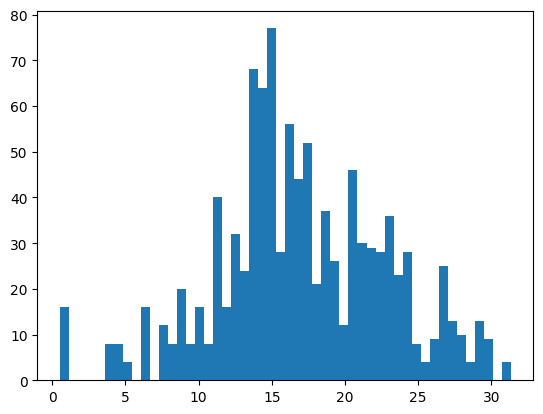

In [10]:
plt.hist(df['_max_proj_error'], bins=50)

In [11]:
df

CLASS_STAR_G_1  CLASS_STAR_R_1  \
_hipscat_index       _hipscat_index                                         
10369096213407465472 10369096213407465472        0.979719        0.983354   
                     10369096213407465472        0.979719        0.983354   
                     10369096213407465472        0.979719        0.983354   
                     10369096213407465472        0.979719        0.983354   
10369096215483645952 10369096215483645952        0.424446         0.24536   
...                                                   ...             ...   
10374223771832680448 10374223771832680448        0.978269        0.592493   
10374223776484163584 10374223776484163584        0.851955        0.969357   
                     10374223776484163584        0.851955        0.969357   
                     10374223776484163584        0.851955        0.969357   
                     10374223776484163584        0.851955        0.969357   

                                           CLASS_STAR_I_1  CLASS_STAR_Z_1  \
_hipscat_index       _hipscat_index                                         
10369096213407465472 10369096213407465472        0.985029        0.983997   
                     10369096213407465472        0.985029        0.983997   
                     10369096213407465472        0.985029        0.983997   
                     10369096213407465472        0.985029        0.983997   
10369096215483645952 10369096215483645952        0.980153         0.83084   
...                                                   ...             ...   
10374223771832680448 10374223771832680448        0.855997        0.185873   
10374223776484163584 10374223776484163584        0.983956         0.97229   
                     10374223776484163584        0.983956         0.97229   
                     10374223776484163584        0.983956         0.97229   
                     10374223776484163584        0.983956         0.97229   

                                           CLASS_STAR_Y_1  FLAGS_G_1  \
_hipscat_index       _hipscat_index                                    
10369096213407465472 10369096213407465472        0.972619          3   
                     10369096213407465472        0.972619          3   
                     10369096213407465472        0.972619          3   
                     10369096213407465472        0.972619          3   
10369096215483645952 10369096215483645952        0.756592          3   
...                                                   ...        ...   
10374223771832680448 10374223771832680448        0.154502          2   
10374223776484163584 10374223776484163584        0.935414          0   
                     10374223776484163584        0.935414          0   
                     10374223776484163584        0.935414          0   
                     10374223776484163584        0.935414          0   

                                           FLAGS_R_1  FLAGS_I_1  FLAGS_Z_1  \
_hipscat_index       _hipscat_index                                          
10369096213407465472 10369096213407465472          3          3          3   
                     10369096213407465472          3          3          3   
                     10369096213407465472          3          3          3   
                     10369096213407465472          3          3          3   
10369096215483645952 10369096215483645952          3          3          3   
...                                              ...        ...        ...   
10374223771832680448 10374223771832680448          2          2          2   
10374223776484163584 10374223776484163584          0          0          0   
                     10374223776484163584          0          0          0   
                     10374223776484163584          0          0          0   
                     10374223776484163584          0          0          0   

                                           FLAGS_Y_1  ...  WAVG_MAG_PSF_Z_2  \
_hipscat